In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import datetime

In [2]:
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [3]:
#read RFMiD csv data RFMiD\Training_Set\Training_Set\RFMiD_Training_Labels.csv
rfmid_train = pd.read_csv('./databases/RFMiD/Training_Set/RFMiD_Training_Labels.csv')
rfmid_test = pd.read_csv('./databases/RFMiD/Test_Set/RFMiD_Testing_Labels.csv')
rfmid_val = pd.read_csv('./databases/RFMiD/Evaluation_Set/RFMiD_Validation_Labels.csv')
rfmid_all = pd.concat([rfmid_train, rfmid_test, rfmid_val])

#get data from RFMiD2 dataset
encoding_rfmid2 = 'ISO-8859-1'
rfmid2_train = pd.read_csv('databases/RFMiD2_0/Training_set/RFMiD_2_Training_labels.csv', encoding= encoding_rfmid2)
rfmid2_test = pd.read_csv('databases/RFMiD2_0/Test_set/RFMiD_2_Testing_labels.csv', encoding= encoding_rfmid2)
rfmid2_val = pd.read_csv('databases/RFMiD2_0/Validation_set/RFMiD_2_Validation_labels.csv', encoding= encoding_rfmid2)
rfmid2_all = pd.concat([rfmid2_train, rfmid2_test, rfmid2_val])

#read ODIR csv data
odir5k_all = pd.read_csv('databases/ODIR-5k/full_df.csv')
odir5k_all = odir5k_all.drop_duplicates(['Left-Fundus', 'Right-Fundus'], keep='first')

In [4]:
#create disease overview df for 1000 images
images_1000_df = pd.DataFrame(columns=['disease_key','path_to_img','dataset_name'])

In [5]:
#create disease overview df for RIPS dataset
images_1000_df = pd.DataFrame(columns=['disease_key','path_to_img','dataset_name'])

In [6]:
ses_df = pd.DataFrame(columns=['disease_key','path_to_img','dataset_name'])

In [7]:
#dataset which has the data of all the datasets
all_images_df = pd.DataFrame(columns=['disease_key','path_to_img','dataset_name'])

In [8]:
#method that adds an entry to an existing dataset
def add_entry_to_dataset(dataset: pd.DataFrame, disease_key : str, path_to_img : str, dataset_name : str):
    #create a new entry
    new_entry = pd.DataFrame([[disease_key, path_to_img, dataset_name]], columns = dataset.columns)
    #append the new entry to the dataset
    dataset_concatinated = pd.concat([dataset, new_entry])
    return dataset_concatinated

In [9]:
abbreviations_map_SES = {'Best': 'Best Disease', 'CD-CRD':'Cone Dystrophie or Cone-rod Dystrophie',
                          'LCA': 'Leber congenital amaurosis', 'RP': 'Retinitis Pigmentosa', 'STGD': 'Stargardt Disease'}

directories_ses = os.listdir('databases/SES')
for directory in directories_ses:
    #get the directorrie path
    directory_path = 'databases/SES/' + directory
    #get the disease key
    disease_key = abbreviations_map_SES[directory]
    for image in os.listdir(directory_path):
        #get the image path
        image_path = directory_path + '/' + image
        #add the entry to the dataset
        ses_df = add_entry_to_dataset(ses_df, disease_key, image_path, 'SES')

In [10]:
regex_1000_images_disease_key = r'\d+\.(\d+\.)?(.+)'
#compile regex
regex_1000_images_disease_key_compiled = re.compile(regex_1000_images_disease_key)
directories_1000_images = os.listdir('databases/1000images')
for directory in directories_1000_images:
    #get the disease key
    disease_key = regex_1000_images_disease_key_compiled.findall(directory)[0][1]
    #get the path to the image
    image_names = os.listdir('databases/1000images/' + directory)
    for image_name in image_names:
        path_to_img = 'databases/1000images/' + directory + '/' + image_name
        #add the entry to the dataset
        images_1000_df = add_entry_to_dataset(images_1000_df, disease_key, path_to_img, '1000images')
    

In [11]:
#do the same for the RIPS dataset
rips_df = pd.DataFrame(columns=['disease_key','path_to_img','dataset_name'])
names_rips = os.listdir('databases/RIPS/RP/')
for name in names_rips:
    #get the disease key
    disease_key = 'retinitis pigmentosa'
    #get the path to the image
    img_original_relative_path = name.replace('_', '/', 3)
    path_to_img = 'databases/RIPS/Original/' + img_original_relative_path
    #add the entry to the dataset
    rips_df = add_entry_to_dataset(rips_df, disease_key, path_to_img, 'RIPS')

In [12]:
#set of all keywords in odir5k
'''disease_keyword = []
keywords_right_splitted = [keywords.split(', ') for keywords in odir5k_all['Right-Diagnostic Keywords']]
keywords_left_splitted = [keywords.split(', ') for keywords in odir5k_all['Left-Diagnostic Keywords']]
disease_keyword.extend(item for sublist in keywords_right_splitted for item in sublist)
disease_keyword.extend(item for sublist in keywords_left_splitted for item in sublist)'''
def extract_eye_keywords(keywords : str, splitter : str):
    keywords_splitted = keywords.split(splitter)
    return set(keywords_splitted)

In [13]:
odir5k_df = pd.DataFrame(columns=['disease_key','path_to_img','dataset_name'])
for index, row in odir5k_all.iterrows():
    #get the disease keys
    keyword_set_left = extract_eye_keywords(row['Left-Diagnostic Keywords'], '，')
    keyword_set_right = extract_eye_keywords(row['Right-Diagnostic Keywords'], '，')
    trainings_images = os.listdir('databases/ODIR-5k/Training Images')
    testing_images = os.listdir('databases/ODIR-5k/Testing Images')
    for left_keyword in keyword_set_left:
        path_to_img_left = ""
        if row['Left-Fundus'] in trainings_images:
            path_to_img_left = 'databases/ODIR-5k/Training Images/' + row['Left-Fundus']
        elif row['Left-Fundus'] in testing_images:
            path_to_img_left = 'databases/ODIR-5k/Testing Images/' + row['Left-Fundus']
        odir5k_df = add_entry_to_dataset(odir5k_df, left_keyword, path_to_img_left, 'ODIR-5k')
    #do the same for the right side
    for right_keyword in keyword_set_right:
        path_to_img_right = ""
        if row['Right-Fundus'] in trainings_images:
            path_to_img_right = 'databases/ODIR-5k/Training Images/' + row['Right-Fundus']
        elif row['Right-Fundus'] in testing_images:
            path_to_img_right = 'databases/ODIR-5k/Testing Images/' + row['Right-Fundus']
        odir5k_df = add_entry_to_dataset(odir5k_df, right_keyword, path_to_img_right, 'ODIR-5k')

In [14]:
rfmid_abbreviation_map = {
    "Disease_Risk": "Normal",
    "DR": "Diabetic Retinopathy",
    "ARMD": "Age-related Macular Degeneration",
    "MH": "Media Haze",
    "DN": "Drusens",
    "MYA": "Myopia",
    "BRVO": "Branch Retinal Vein Occlusion",
    "TSLN": "Tessellation",
    "ERM": "Epiretinal Membrane",
    "LS": "Laser Scars",
    "MS": "Macular Scar",
    "CSR": "Central Serous Retinopathy",
    "ODC": "Optic Disc Cupping",
    "CRVO": "Central Retinal Vein Occlusion",
    "TV": "Tortuous Vessels",
    "AH": "Asteroid Hyalosis",
    "ODP": "Optic Disc Pallor",
    "ODE": "Optic Disc Edema",
    "ST": "Optociliary Shunt",
    "AION": "Anterior Ischemic Optic Neuropathy",
    "PT": "Parafoveal Telangiectasia",
    "RT": "Retinal Traction",
    "RS": "Retinitis",
    "CRS": "Chorioretinitis",
    "EDN": "Exudation",
    "RPEC": "Retinal Pigment Epithelium Changes",
    "MHL": "Macular Hole",
    "RP": "Retinitis Pigmentosa",
    "CWS": "Cotton-Wool Spots",
    "CB": "Coloboma",
    "ODPM": "Optic Disc Pit Maculopathy",
    "PRH": "Preretinal Hemorrhage",
    "MNF": "Myelinated Nerve Fibers",
    "HR": "Hemorrhagic Retinopathy",
    "CRAO": "Central Retinal Artery Occlusion",
    "TD": "Tilted Disc",
    "CME": "Cystoid Macular Edema",
    "PTCR": "Post-Traumatic Choroidal Rupture",
    "CF": "Choroidal Folds",
    "VH": "Vitreous Hemorrhage",
    "MCA": "Macroaneurysm",
    "VS": "Vasculitis",
    "BRAO": "Branch Retinal Artery Occlusion",
    "PLQ": "Plaque",
    "HPED": "Hemorrhagic Pigment Epithelial Detachment",
    "CL": "Collateral"
}

In [15]:
def extract_data_from_rmid(source_df: pd.DataFrame, target_df : pd.DataFrame, folder_path: str,  abbreviation_map : dict , dataset_name: str, file_format: str = 'png'):
    result_df = target_df
    for abbreviation in abbreviation_map.keys():
        #get all the images for the abberation
        try:
            images = source_df[source_df[abbreviation] == 1]
        except:
            continue
        for index, row in images.iterrows():
            #get the path to the image
            path_to_img = folder_path + str(int(row['ID'])) + '.' + file_format
            #add the entry to the dataset
            result_df = add_entry_to_dataset(result_df, abbreviation_map[abbreviation], path_to_img, dataset_name)
    return result_df

In [16]:
#extract data from the RFMiD datasets
rfmid_df = pd.DataFrame(columns=['disease_key','path_to_img','dataset_name'])
rfmid_df = pd.concat([extract_data_from_rmid(rfmid_train ,rfmid_df, 'databases/RFMiD/Training_Set/Training/', abbreviation_map= rfmid_abbreviation_map, dataset_name='RFMiD'),
extract_data_from_rmid(rfmid_test,rfmid_df, 'databases/RFMiD/Test_Set/Test/', abbreviation_map= rfmid_abbreviation_map, dataset_name='RFMiD'),
extract_data_from_rmid(rfmid_val,rfmid_df, 'databases/RFMiD/Evaluation_Set/Validation/', abbreviation_map= rfmid_abbreviation_map, dataset_name='RFMiD')])

In [17]:
rfmid2_abbreviation_map = {
    "WNL": "Normal",
    "BRVO": "Branch Retinal Vein Occlusion",
    "CB": "Coloboma",
    "CF": "Choroidal Folds",
    "CL": "Collateral",
    "ME": "Macular Edema",
    "NV": "Neovascularization",
    "CRAO": "Central Retinal Artery Occlusion",
    "CRS": "Chorioretinitis",
    "CRVO": "Central Retinal Vein Occlusion",
    "CSC": "Cysticercosis",
    "CWS": "Cotton Wool Spots",
    "DN": "Drusens",
    "DR": "Diabetic Retinopathy",
    "EX": "Exudation",
    "ERM": "Epiretinal Membrane",
    "GRT": "Giant Retinal Tear",
    "HPED": "Hemorrhagic Pigment Epithelial Detachment",
    "IIH": "Idiopathic Intracranial Hypertension",
    "HTR": "Hypertensive Retinopathy",
    "HR": "Haemorrhagic Retinopathy",
    "LS": "Laser Scar",
    "MCA": "Microaneurysm",
    "MH": "Media Haze",
    "MHL": "Macular Hole",
    "MS": "Macular Scar",
    "MYA": "Myopia",
    "ODC": "Optic Disc Cupping",
    "ODE": "Optic Disc Edema",
    "ODP": "Optic Disc Pallor",
    "ON": "Optic Neuritis",
    "ODPM": "Optic Disc Pit Maculopathy",
    "PRH": "Preretinal Hemorrhage",
    "RD": "Retinal Detachment",
    "RHL": "Retinal Holes",
    "RTR": "Retinal Tears",
    "RP": "Retinitis Pigmentosa",
    "RPEC": "Retinal Pigment Epithelium Changes",
    "RS": "Retinitis",
    "RT": "Retinal Traction",
    "SOFE": "Silicone Oil-Filled Eye",
    "ST": "Optociliary Shunt",
    "TD": "Tilted Disc",
    "TSLN": "Tessellation",
    "TV": "Tortuous Vessels",
    "VS": "Vasculitis"
}

In [18]:
rfmid2_df = pd.DataFrame(columns=['disease_key','path_to_img','dataset_name'])
file_format = 'jpg'
rfmid2_df = pd.concat([extract_data_from_rmid(rfmid2_train ,rfmid2_df, 'databases/RFMiD2_0/Training_set/', file_format= file_format, abbreviation_map= rfmid2_abbreviation_map, dataset_name='RFMiD2'),
extract_data_from_rmid(rfmid2_test,rfmid2_df, 'databases/RFMiD2_0/Test_set/', file_format= file_format, abbreviation_map= rfmid2_abbreviation_map, dataset_name='RFMiD2'),
extract_data_from_rmid(rfmid2_val,rfmid2_df, 'databases/RFMiD2_0/Validation_set/', file_format= file_format, abbreviation_map= rfmid2_abbreviation_map, dataset_name='RFMiD2')])

In [19]:
#combine all the created dfs
all_images_df = pd.concat([images_1000_df, rips_df, odir5k_df, rfmid_df, rfmid2_df, ses_df])
#save as csv
all_images_df.to_csv('all_images_df.csv', index=False)

In [20]:
#show all the images of which the disease key is not longer than 5 characters
short_notations = all_images_df[all_images_df['disease_key'].str.len() <= 5]
#print the keys
set(short_notations['disease_key'])

{'BRVO', 'CRVO', 'CSCR', 'DR1', 'DR2', 'DR3', 'ERM', 'MH', 'RAO'}

In [21]:
disease_abbreviations = {
    'BRVO': 'Branch Retinal Vein Occlusion',
    'CRVO': 'Central Retinal Vein Occlusion',
    'CSCR': 'Central Serous Chorioretinopathy',
    'DR1': 'Diabetic Retinopathy',
    'DR2': 'Diabetic Retinopathy',
    'DR3': 'Diabetic Retinopathy',
    'ERM': 'Epiretinal Membrane',
    'MH': 'Macular Hole',
    'RAO': 'Retinal Artery Occlusion',
    'normal fundus': 'Normal',
}


In [22]:
#if the disease key is in the disease_abbreviations dict, replace the disease key with the value of the dict
all_images_df['disease_key'] = all_images_df['disease_key'].map(lambda x: disease_abbreviations.get(x, x))

In [23]:
all_images_df.to_csv('all_images_df.csv', index=False)

In [24]:
#get all the values of the rfmid2_abbreviation_map
not_summarize_set = set(rfmid2_abbreviation_map.values()).union(set(rfmid_abbreviation_map.values()))

In [25]:
#create a set of all the disease keys
disease_keys = set(all_images_df['disease_key'])
disease_keys = list(disease_keys)
#sort disease keys by length
disease_keys.sort(key=lambda x: (len(x), x))
#create a map of disease keys in which a disease key contains a different disease key is mapped to the disease key ignoring special characters spaces and capital letters
disease_key_map = {}
for disease_key in disease_keys:
    if disease_key not in disease_key_map.keys():
        for disease_key2 in disease_keys:
            disease_key_modified = disease_key.lower().replace(' ', '').replace('-', '').replace('_', '')
            disease_key2_modified = disease_key2.lower().replace(' ', '').replace('-', '').replace('_', '')
            summarize = not (disease_key2 in not_summarize_set and disease_key in not_summarize_set)
            if disease_key != disease_key2 and summarize:
                #check if disease_key2 is in disease_key
                if disease_key_modified in disease_key2_modified:
                    disease_key_map[disease_key2] = disease_key

In [26]:
#if the disease key is in the disease_abbreviations dict, replace the disease key with the value of the dict
all_images_df['disease_key'] = all_images_df['disease_key'].map(lambda x: disease_key_map.get(x, x))
#save the dataframe as csv
all_images_df.to_csv('all_images_grouped_df.csv', index=False)

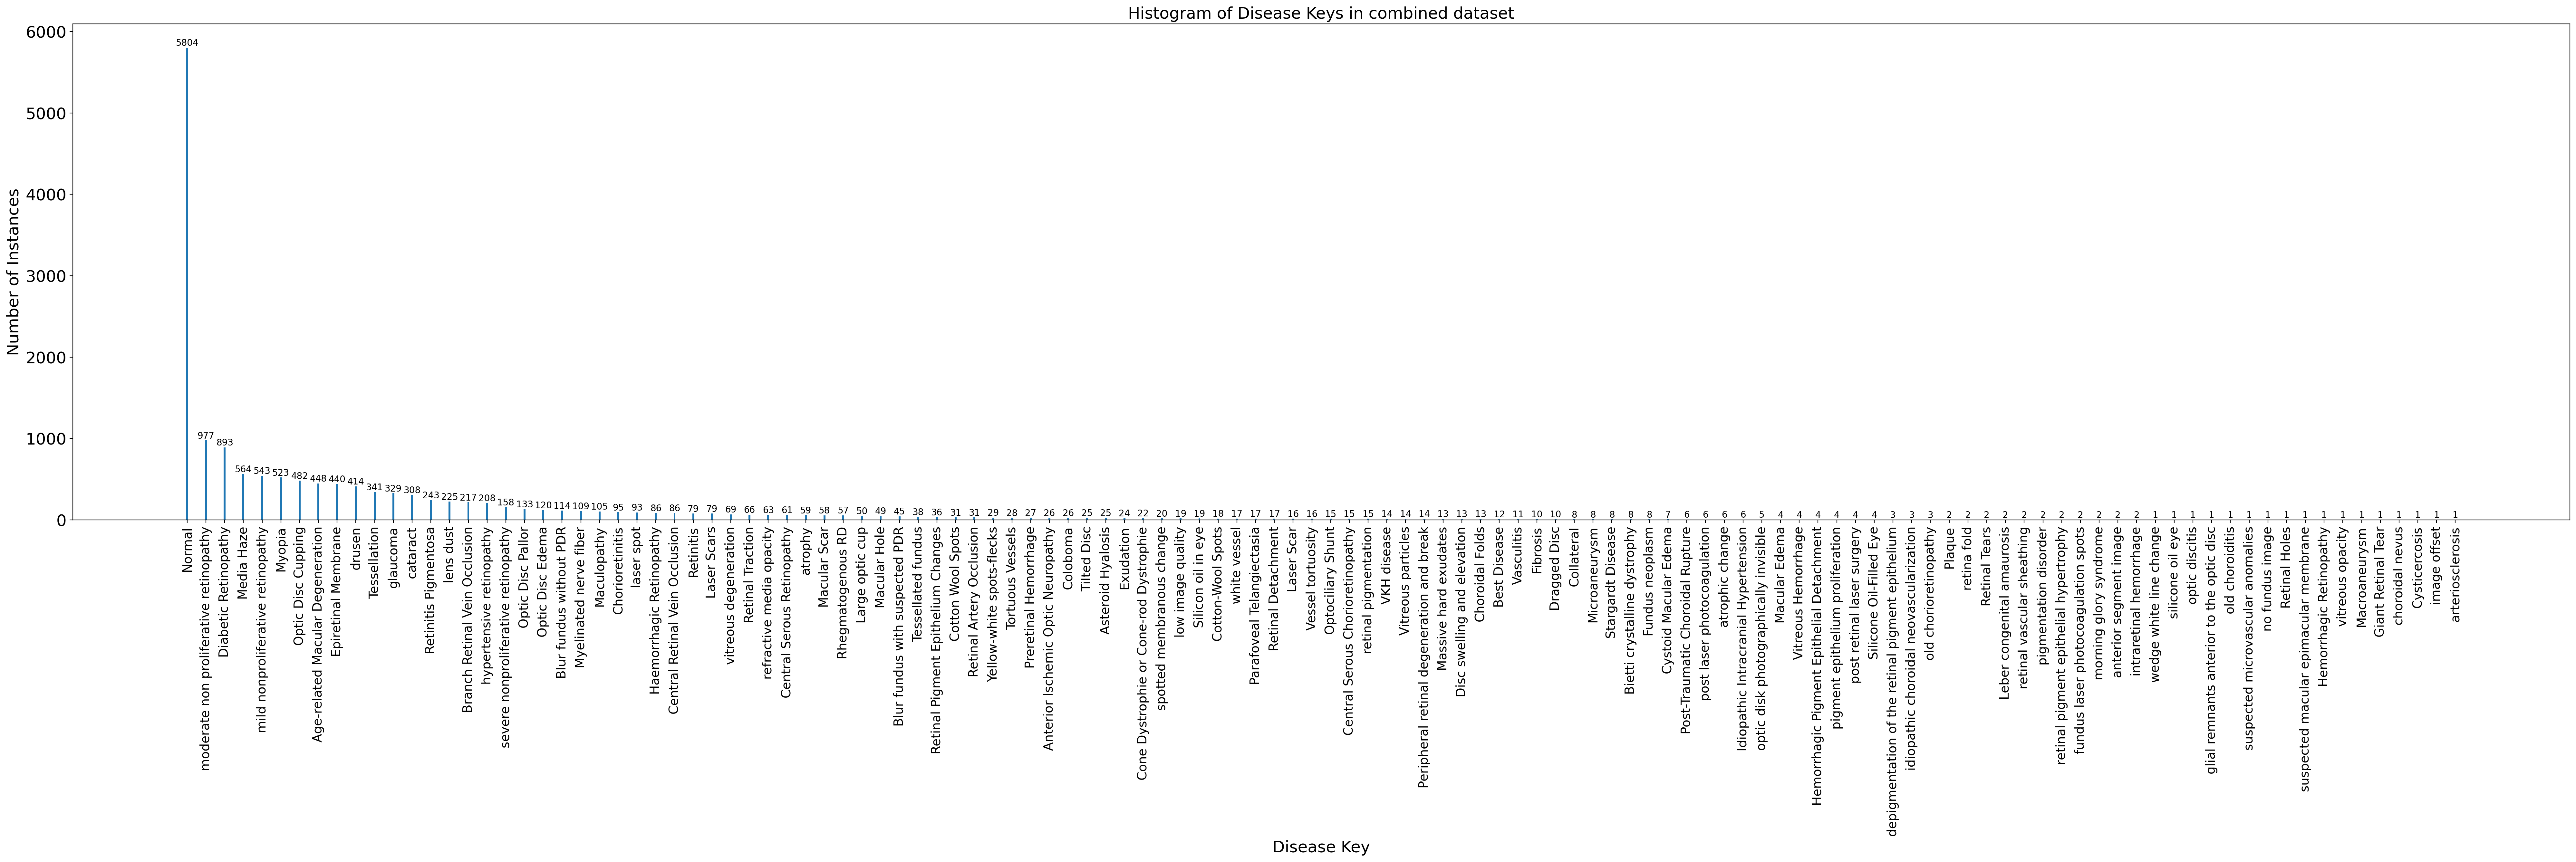

In [27]:
#historgam of the disease keys
# Count the number of instances for each class
counts = all_images_df['disease_key'].value_counts()

# Create a bar plot
plt.figure(figsize=(50, 10), dpi=200)
bars = plt.bar(counts.index, counts.values, width=0.1)
# Annotate each bar with its height
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=10)

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=18)
plt.xlabel('Disease Key', fontsize=18)
plt.ylabel('Number of Instances', fontsize=18)
plt.title('Histogram of Disease Keys in combined dataset', fontsize=18)
plt.show()

In [28]:
#find out how many unique image paths there are
unique_image_paths = set(all_images_df['path_to_img'])
print(len(unique_image_paths))
#do the same for the for the disease keys in the grouped df
unique_disease_keys = set(all_images_df['disease_key'])
print(len(unique_disease_keys))


11284
122


In [29]:
df = pd.DataFrame(columns=all_images_df['disease_key'].unique(), index=all_images_df['disease_key'].unique())
#save as csv
df.to_excel(f'similarity_matrices/{date}_disease_key_matrix.xlsx', index=True)

In [30]:
#checkpoint
all_images_df = pd.read_csv('all_images_grouped_df.csv')

In [31]:
sim_table = pd.read_excel('similarity_matrices/2023-12-27_15-25-54_disease_key_matrix.xlsx')
#set index to column named Spalte1
sim_table.set_index('Spalte1', inplace=True)

In [32]:

diseases_of_interest = ['Retinitis Pigmentosa']
#only keep the diseases of interest columns and the index
sim_table_interest = sim_table[diseases_of_interest]

In [33]:
import numpy as np
def map_diseases(disease_of_interest : str, disease_key : str):
    mapping = sim_table_interest.loc[disease_key, disease_of_interest]
    if pd.isna(mapping):
        return disease_key
    if 'sa' in mapping:
        return disease_of_interest
    else:
        return disease_key


In [34]:
#apply the mapping to the disease keys
for disease_of_interest in diseases_of_interest:
    all_images_df['disease_key'] = all_images_df['disease_key'].map(lambda x: map_diseases(disease_of_interest, x))


In [35]:
#save the dataframe as csv
all_images_df.to_csv('all_images_grouped_df.csv', index=False)

In [36]:
#filter all the nan values from the disease table of interest
for interesting_disease in diseases_of_interest:
    sim_table_interest = sim_table_interest[sim_table_interest[interesting_disease].notna()]
sim_table_interest

,Retinitis Pigmentosa
Spalte1,
Age-related Macular Degeneration,si for a non expert in retina
Best Disease,si for a non expert in retina
Bietti crystalline dystrophy,si for a non expert in retina
cataract,"ns, but worth training the algorithm to detect..."
Cone Dystrophie or Cone-rod Dystrophie,si for a non expert in retina
Diabetic Retinopathy,"ns, but worth training the algorithm to detect..."
glaucoma,"ns, but worth training the algorithm to detect..."
Leber congenital amaurosis,si for a non expert in retina
Maculopathy,si for a non expert in retina


In [37]:
#filter out diseases which are not in the all_images_df
sim_table_interest = sim_table_interest[sim_table_interest.index.isin(all_images_df['disease_key'])]
sim_table_interest


,Retinitis Pigmentosa
Spalte1,
Age-related Macular Degeneration,si for a non expert in retina
Best Disease,si for a non expert in retina
Bietti crystalline dystrophy,si for a non expert in retina
cataract,"ns, but worth training the algorithm to detect..."
Cone Dystrophie or Cone-rod Dystrophie,si for a non expert in retina
Diabetic Retinopathy,"ns, but worth training the algorithm to detect..."
glaucoma,"ns, but worth training the algorithm to detect..."
Leber congenital amaurosis,si for a non expert in retina
Maculopathy,si for a non expert in retina


In [38]:
#create a dataframe which only contains the diseases which are in the index column of the sim_table_interest
disease_keys = list(sim_table_interest.index)
#filter all_images_df by the disease keys
all_images_df_interest = all_images_df[all_images_df['disease_key'].isin(disease_keys)]

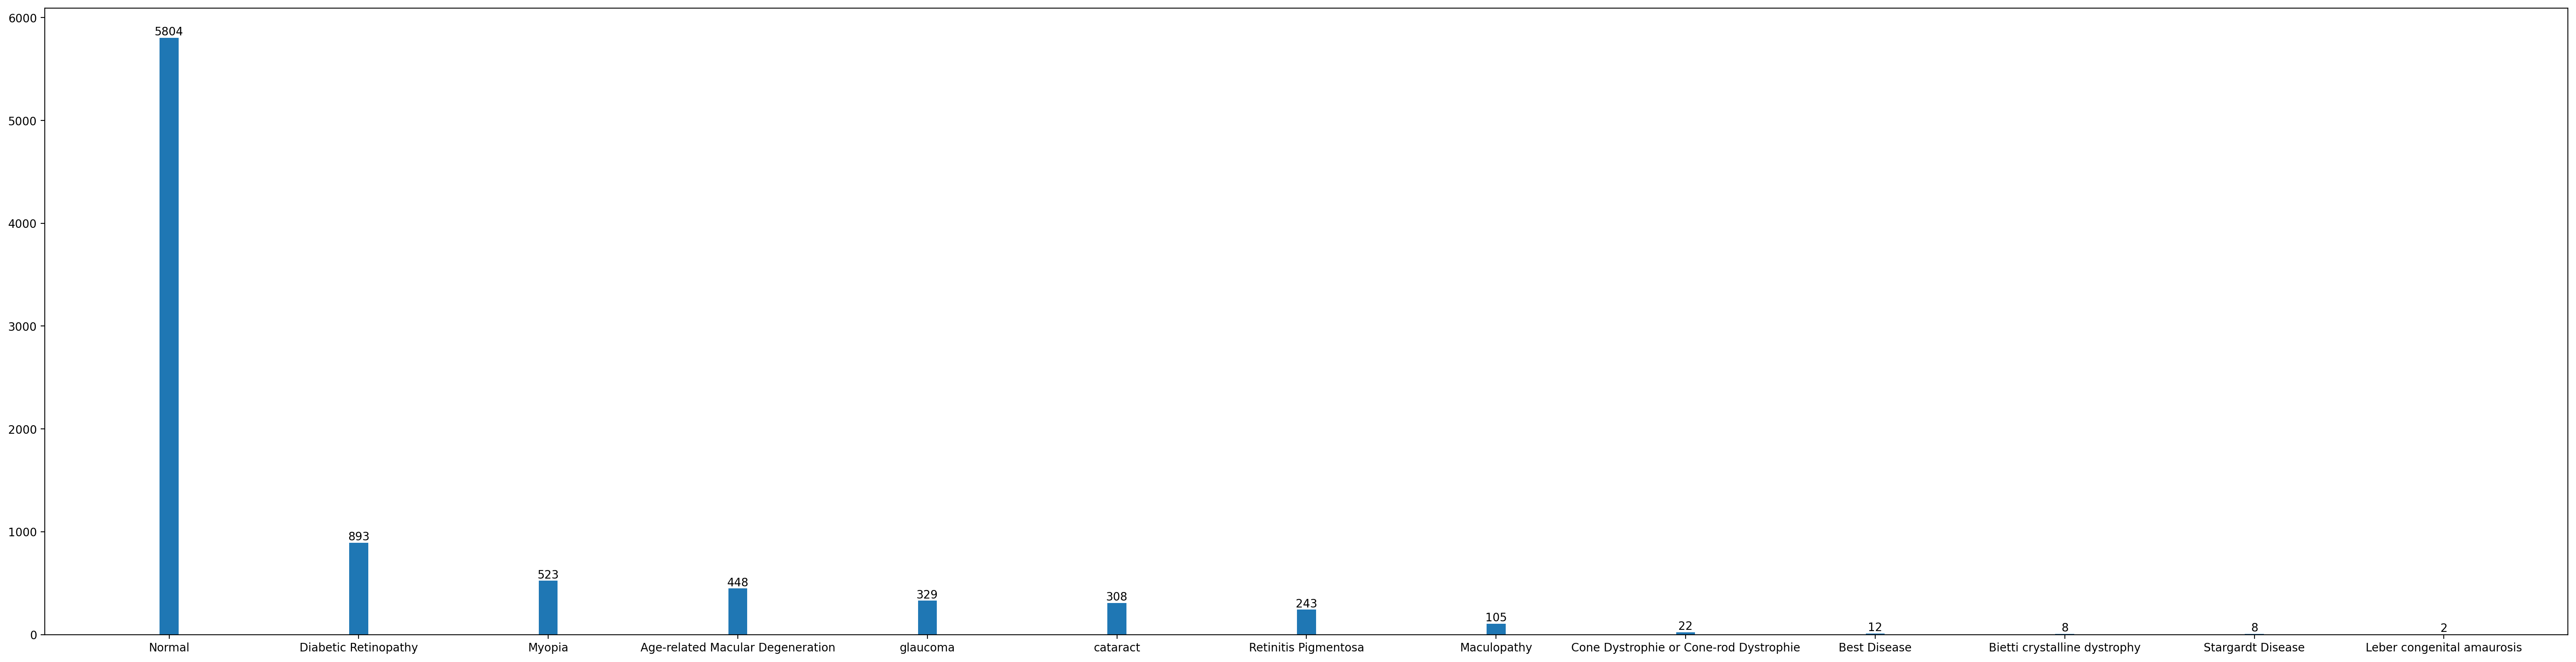

In [39]:
#plot disease distribution of the all_images_df_interest
# Count the number of instances for each class
counts = all_images_df_interest['disease_key'].value_counts()
# Create a bar plot
plt.figure(figsize=(40, 10), dpi=200)
bars = plt.bar(counts.index, counts.values, width=0.1)
# Annotate each bar with its height
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=10)
plt.savefig(f'dataset_plots/{date}_dataset_distribution.png')

In [40]:
#drop from each diseases as many images as necessary so the number of images is equal to the number of images of the disease which has the median number of images
median = counts.iloc[len(counts)//2 - 1]
#check which disease has more images than  1.3*median
diseases_to_drop = []
for disease_key, count in counts.items():
    if count > 1.3*median:
        diseases_to_drop.append((disease_key, int(count - 1.3* median)))
print(diseases_to_drop)

[('Normal', 5403), ('Diabetic Retinopathy', 492), ('Myopia', 122), ('Age-related Macular Degeneration', 47)]


In [41]:
def random_drop(df : pd.DataFrame, disease_key : str, number_of_images_to_drop : int):
    #get all the images of the disease key
    images_of_disease = df[df['disease_key'] == disease_key]
    #drop the images
    images_to_drop = images_of_disease.sample(number_of_images_to_drop, random_state=42)
    df = df.drop(images_to_drop.index)
    return df

In [44]:
#drop images from the all_images_df_interest
for disease_key, number_of_images_to_drop in diseases_to_drop:
    all_images_df_interest = random_drop(all_images_df_interest, disease_key, number_of_images_to_drop)
#drop classes which have less than 3 images
counts = all_images_df_interest['disease_key'].value_counts()
diseases_to_drop = []
for disease_key, count in counts.items():
    if count < 3:
        diseases_to_drop.append(disease_key)
for disease_key in diseases_to_drop:
    all_images_df_interest = all_images_df_interest[all_images_df_interest['disease_key'] != disease_key]
#plot new disease distribution
# Count the number of instances for each class
# Create a bar plot
plt.figure(figsize=(40, 10), dpi=200)
bars = plt.bar(counts.index, counts.values, width=0.1)
# Annotate each bar with its height
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=10)
plt.savefig(f'dataset_plots/{date}_dataset_distribution_after_drop.png')

ValueError: too many values to unpack (expected 2)

In [43]:
#create dataset from the all_images_df_interest
#create a folder for each disease key
import os
import shutil
for disease_key in all_images_df_interest['disease_key'].unique():
    #create a folder for each disease key
    if not os.path.exists(f'datasets/{date}/' + disease_key):
        os.makedirs(f'datasets/{date}/' + disease_key)
    #get all the images for the disease key
    images = all_images_df_interest[all_images_df_interest['disease_key'] == disease_key]
    #copy the images to the folder
    for index, row in images.iterrows():
        #copy the image to the folder
        try:
            destination_path = f'datasets/{date}/{disease_key}'
            unique_destination_path = f'datasets/{date}/{disease_key}'
            image_name = os.path.basename(row['path_to_img'])
            unique_name = '/'+ '_'.join(row['path_to_img'].split('/')[:-1])
            shutil.copy(row['path_to_img'], f'datasets/{date}/{disease_key}')
            os.rename(destination_path + '/' + image_name, destination_path + f'{unique_name}_{image_name}')
        except:
            #print('could not copy image: ' + row['path_to_img'])
            print('could not rename image: ' + row['path_to_img'], destination_path + '/' + f'{unique_name}_{image_name}')
            continue

could not rename image: databases/ODIR-5k/Training Images/2074_right.jpg datasets/2023-12-28_18-12-43/cataract//databases_ODIR-5k_Training Images_2074_right.jpg
